### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

### Importing cleaned dataset

In [2]:
# Importing cleaned dataset and dropping old index

retail = pd.read_csv('./dataset/retail.csv')
retail = retail.drop('Unnamed: 0', axis=1)
retail.head()

,Branch,YearMonth,Weekday,Hour,Product line,Unit price,Quantity,Total,Rating
0,A,2019-01,5,13,Health and beauty,74.69,7,548.9715,9.1
1,C,2019-03,4,10,Electronic accessories,15.28,5,80.2200,9.6
2,A,2019-03,6,13,Home and lifestyle,46.33,7,340.5255,7.4
3,A,2019-01,6,20,Health and beauty,58.22,8,489.0480,8.4
4,A,2019-02,4,10,Sports and travel,86.31,7,634.3785,5.3


### First insights

In [3]:
retail.describe()

,Weekday,Hour,Unit price,Quantity,Total,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,991.000000,1000.00000
mean,3.032000,14.910000,55.672130,5.510000,316.604752,6.97270
std,1.973543,3.186857,26.494628,2.923431,237.709589,1.71858
min,0.000000,10.000000,10.080000,1.000000,10.678500,4.00000
25%,1.000000,12.000000,32.875000,3.000000,122.167500,5.50000
50%,3.000000,15.000000,55.230000,5.000000,252.756000,7.00000
75%,5.000000,18.000000,77.935000,8.000000,464.667000,8.50000
max,6.000000,20.000000,99.960000,10.000000,951.825000,10.00000


- The mean is most of the time closed to the median which shows that the data is concentrated around the mean.
- Unit price (in USD): between 10.08 to 99.96 with an average of 55.67
- Quantity: between 1 and 10 with a median of 5 - the buyers don't buy many articles at once
- Total spent (in USD): between 10ish to 951.82 with an average around 316
- Ratings: between 4 and 10 with a mean of 6.97

In [4]:
retail.columns

Index(['Branch', 'YearMonth', 'Weekday', 'Hour', 'Product line', 'Unit price',
       'Quantity', 'Total', 'Rating'],
      dtype='object')

### 1. Can we see different customer behavior depending on the branches?

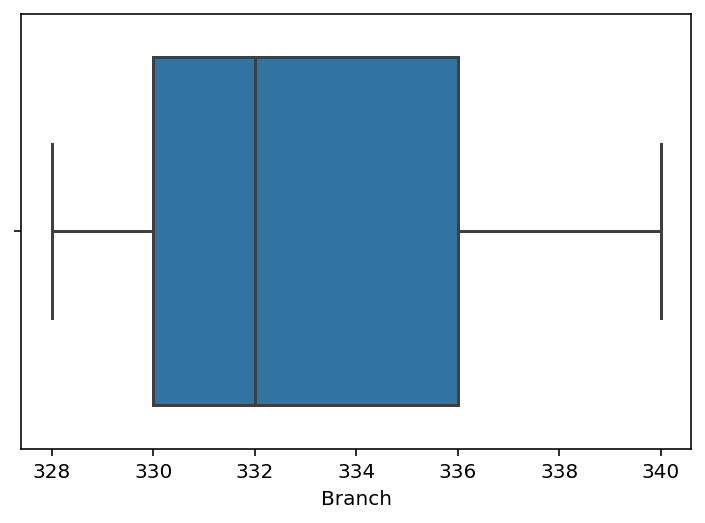

In [8]:
# Checking distribution
sns.boxplot(x = retail["Branch"].value_counts())
plt.show()

In [ ]:
branch_a = retail.loc[(retail.Branch == 'A')]

In [ ]:
branch_a